In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
data = '/content/drive/Shareddrives/For_Research_S/Smart_Irrigation/sensor_data.csv'
sensor_data = pd.read_csv(data)

In [4]:
# Display the first few rows and summary statistics of the dataset
sensor_data.head()

,Time,Moisture(%),Temperature(C),Humidity(%),Motor,Raindrop,Object
0,0:00:00,91.0,24.1,77.0,OFF,NO,NOT FOUND
1,0:00:01,91.0,24.1,77.0,OFF,NO,NOT FOUND
2,0:00:02,92.0,24.1,77.0,OFF,NO,NOT FOUND
3,0:00:03,92.0,24.1,77.0,OFF,NO,NOT FOUND
4,0:00:04,91.0,24.1,77.0,OFF,NO,NOT FOUND


In [5]:
sensor_data.describe()

,Moisture(%),Temperature(C),Humidity(%)
count,1.040740e+06,1.040298e+06,1.040298e+06
mean,7.221238e+01,2.659993e+01,6.516127e+01
std,1.609280e+01,4.752611e+00,1.349340e+01
min,0.000000e+00,2.340000e+01,1.800000e+01
25%,6.500000e+01,2.380000e+01,5.800000e+01
50%,7.700000e+01,2.410000e+01,7.100000e+01
75%,8.400000e+01,2.760000e+01,7.400000e+01
max,1.000000e+02,4.820000e+01,8.000000e+01


In [6]:
sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040757 entries, 0 to 1040756
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Time            1040757 non-null  object 
 1   Moisture(%)     1040740 non-null  float64
 2   Temperature(C)  1040298 non-null  float64
 3   Humidity(%)     1040298 non-null  float64
 4   Motor           1040298 non-null  object 
 5   Raindrop        1040298 non-null  object 
 6   Object          1040298 non-null  object 
dtypes: float64(3), object(4)
memory usage: 55.6+ MB


In [7]:
sensor_data.isnull().sum()

,0
Time,0
Moisture(%),17
Temperature(C),459
Humidity(%),459
Motor,459
Raindrop,459
Object,459


In [8]:
for column in sensor_data.columns:
  sensor_data[column] = sensor_data[column].fillna(sensor_data[column].mode()[0])

In [9]:
sensor_data.isnull().sum()

,0
Time,0
Moisture(%),0
Temperature(C),0
Humidity(%),0
Motor,0
Raindrop,0
Object,0


#Pre-processing

In [10]:
# Convert categorical columns to numerical
sensor_data['Motor'] = sensor_data['Motor'].map({'ON': 1, 'OFF': 0})
sensor_data['Raindrop'] = sensor_data['Raindrop'].map({'YES': 1, 'NO': 0})
sensor_data['Object'] = sensor_data['Object'].map({'FOUND': 1, 'NOT FOUND': 0})
sensor_data.drop('Object', axis=1, inplace=True)

In [11]:
# Convert 'Time' to datetime and create a 'Session' column to distinguish different sessions
sensor_data['Time'] = pd.to_datetime(sensor_data['Time'], format='%H:%M:%S')
sensor_data['Session'] = (sensor_data['Time'].diff() < pd.Timedelta(seconds=0)).cumsum()

In [12]:
# Aggregate data in 5-minute intervals within each session
sensor_data.set_index('Time', inplace=True)
aggregated_data = sensor_data.groupby(['Session', pd.Grouper(freq='5T')]).mean().reset_index()

In [13]:
# Display the first few rows of the processed dataset
aggregated_data.head()

,Session,Time,Moisture(%),Temperature(C),Humidity(%),Motor,Raindrop
0,0,1900-01-01 00:00:00,78.875000,32.257143,51.392857,0.160714,0.071429
1,0,1900-01-01 00:05:00,73.703571,33.828571,40.625000,0.278571,0.228571
2,0,1900-01-01 00:10:00,67.747331,27.993594,53.362989,0.224199,0.245552
3,0,1900-01-01 00:15:00,73.245552,29.869395,49.946619,0.000000,0.380783
4,0,1900-01-01 00:20:00,71.697509,29.680071,55.078292,0.309609,0.281139


Null Value checking

In [14]:
# Count occurrences of each unique value in y_test
unique_vals, counts = np.unique(aggregated_data['Motor'], return_counts=True)

# Sort the unique values and counts based on counts
sorted_indices = np.argsort(unique_vals)
unique_vals = unique_vals[sorted_indices]

print(unique_vals)
print(counts)

[0.         0.0747331  0.09964413 0.10676157 0.11032028 0.12811388
 0.15302491 0.16071429 0.16370107 0.17857143 0.22419929 0.25622776
 0.26428571 0.27758007 0.27857143 0.29537367 0.29642857 0.30960854
 0.32384342 0.37446809 0.39145907 0.40357143 0.47330961 0.475
 0.52313167 0.52669039 0.53024911 0.59074733 0.62989324 0.74377224
 0.95283019 1.        ]
[1258  170   17  306  136   17  170   17  136  136   17   17  170  136
   17  136  136   17   17   34   34   34   34   34   34   34   34  136
   34  136  136  136]


Threshold Setup

In [15]:
import numpy as np
from collections import Counter

# Count occurrences of unique values and sort
counts = Counter(aggregated_data['Motor'])
sorted_counts = sorted(counts.items())

# Calculate the target sum
total_count = sum(counts.values())
target_sum = np.ceil(total_count / 2)

# Find the threshold
cumulative_sum = 0
threshold = None
for value, count in sorted_counts:
  cumulative_sum += count
  if cumulative_sum >= target_sum:
    threshold = value
    break

print("Threshold:", threshold)

Threshold: 0.15302491103202848


In [16]:
# Define a threshold to convert continuous motor values to binary
threshold_v = threshold
aggregated_data['Motor'] = (aggregated_data['Motor'] >= threshold_v).astype(int)

In [17]:
# Define features and target variable
X = aggregated_data.drop(columns=['Motor'])
y = aggregated_data['Motor']

# Check the number of samples
print("Number of samples:", len(X))

Number of samples: 3876


In [18]:
# Define features and target variable
X = aggregated_data.drop(columns=['Motor', 'Session', 'Time'])
y = aggregated_data['Motor']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random Forest Classifier

In [19]:
# Train a RandomForest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [20]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [21]:
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

# Predict the irrigation times based on sensor data
predicted_irrigation_times = model.predict(X_test)

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       361
           1       1.00      1.00      1.00       415

    accuracy                           1.00       776
   macro avg       1.00      1.00      1.00       776
weighted avg       1.00      1.00      1.00       776



In [22]:
# Predict the irrigation times based on sensor data
predicted_irrigation_times = model.predict(X_test)

# Interpret results: intervals when irrigation is needed
irrigation_times = X_test[predicted_irrigation_times == 1].index
print("Best irrigation times (5-min intervals):", irrigation_times)

Best irrigation times (5-min intervals): Index([2500, 2240, 2730,  952, 2117,  325, 2086, 1866, 1360, 1878,
       ...
       3728, 3608, 3384, 2932,  650, 1563, 1068, 1565, 3648,  691],
      dtype='int64', length=415)


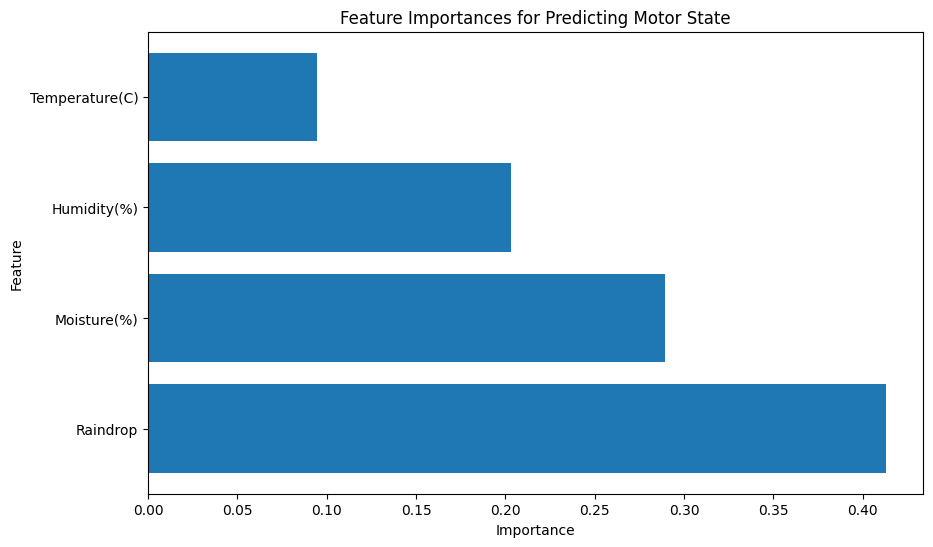

In [23]:
import matplotlib.pyplot as plt

# Get feature importances from the model
feature_importances = model.feature_importances_

# Map feature importances to feature names
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Predicting Motor State')
plt.show()

In [24]:
# Access original data for best irrigation times
best_irrigation_data = aggregated_data.iloc[irrigation_times]

# Calculate average values for relevant columns
avg_raindrop = best_irrigation_data['Raindrop'].mean()
avg_temperature = best_irrigation_data['Temperature(C)'].mean()
avg_humidity = best_irrigation_data['Humidity(%)'].mean()
avg_moisture = best_irrigation_data['Moisture(%)'].mean()

# Print the average values
#print(f"Average Raindrop: {avg_raindrop}")
#print(f"Average Temperature: {avg_temperature} %")
#print(f"Average Humidity: {avg_humidity} %")
#print(f"Average Moisture: {avg_moisture} %")

print(f'Farmers should apply irrigation in his land when  - \n Raindrop is {avg_raindrop}, \n Temperature is {avg_temperature} %,\n Humidity is {avg_humidity} %,\n Moisture is {avg_moisture} %')


Farmers should apply irrigation in his land when  - 
 Raindrop is 0.05436136003087082, 
 Temperature is 27.63269521992441 %,
 Humidity is 62.68265879084821 %,
 Moisture is 68.90152747046066 %


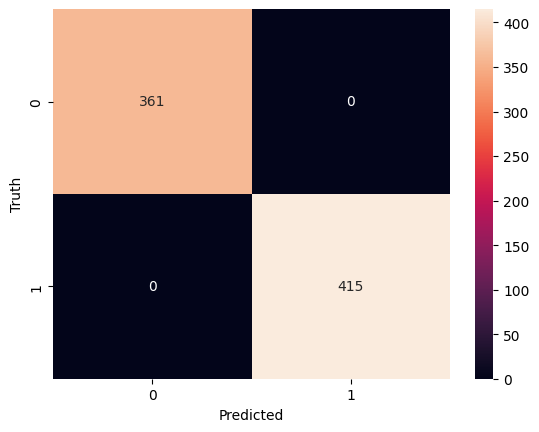

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

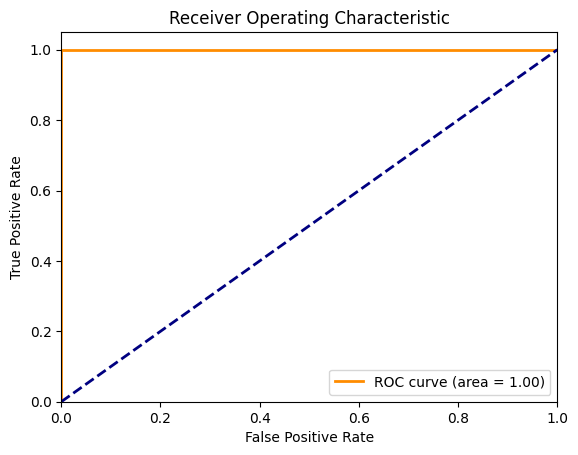

In [26]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()